# Predicting House Sale Prices

Here I will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected here. 

* Info about the dataset here: https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627
* Dataset can be downloaded here: http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold

import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('AmesHousing.tsv', delimiter="\t")

In [3]:
data.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [4]:
data.dtypes

Order               int64
PID                 int64
MS SubClass         int64
MS Zoning          object
Lot Frontage      float64
Lot Area            int64
Street             object
Alley              object
Lot Shape          object
Land Contour       object
Utilities          object
Lot Config         object
Land Slope         object
Neighborhood       object
Condition 1        object
Condition 2        object
Bldg Type          object
House Style        object
Overall Qual        int64
Overall Cond        int64
Year Built          int64
Year Remod/Add      int64
Roof Style         object
Roof Matl          object
Exterior 1st       object
Exterior 2nd       object
Mas Vnr Type       object
Mas Vnr Area      float64
Exter Qual         object
Exter Cond         object
                   ...   
Bedroom AbvGr       int64
Kitchen AbvGr       int64
Kitchen Qual       object
TotRms AbvGrd       int64
Functional         object
Fireplaces          int64
Fireplace Qu       object
Garage Type 

## Feature Transformation

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. 
* First we'll update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. We will also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). 

In general, the goal of this function is to:
* remove features that we don't want to use in the model, just based on the number of missing values or data leakage
* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
* create new features by combining other features

In [5]:
def transform_features(df):
    new_df = df.copy()
    
    print('Drop any column from the data frame with more than 25% missing values')
    total_rows = new_df.shape[0] #compute total number of rows
    cols_missing_too_much_data = []
    for col in data:
       if (data[col].isnull().sum())/total_rows >= .25:
        cols_missing_too_much_data.append(col)
    new_df = new_df.drop(columns=cols_missing_too_much_data, axis=1)
    
    print('For numerical columns with less than 5% missing values, fill in with the most popular value (mode)')
    total_rows = new_df.shape[0] #compute total number of rows
    numerical_columns = new_df.select_dtypes(include=['number']).columns #find only numerical columns
    #print(new_df[numerical_columns].isnull().sum()) #find number of nulls before transformation, for validation
    for column in numerical_columns:
        if (new_df[column].isnull().sum())/total_rows <= .05: #Only replace columns with less than 5% missing values
            new_df[column].fillna(new_df[column].mode()[0], inplace=True) #use the mode for missing values
    #print(new_df[numerical_columns].isnull().sum()) #find number of nulls after transformation, for validation
    
    print('Add column that computes the year until home was remodeled')
    new_df['years_until_remod']=new_df['Year Remod/Add']-new_df['Year Built']
    
    print('Drop columns that are not useful or leak data about the final sale')
    columns_to_drop=['Order', 'PID', 'MS SubClass', 'Lot Frontage',
       'Street', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type',
       'Sale Condition', 'Garage Yr Blt', 'Year Built']
    new_df = new_df.drop(columns=columns_to_drop, axis=1)
    
    return new_df
new_df = transform_features(data)
new_df


Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale


,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,SalePrice,years_until_remod
0,RL,31770,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,P,210,62,0,0,0,0,215000,0
1,RH,11622,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,TA,Y,140,0,0,0,120,0,105000,0
2,RL,14267,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,Y,393,36,0,0,0,0,172000,0
3,RL,11160,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,TA,Y,0,0,0,0,0,0,244000,0
4,RL,13830,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Y,212,34,0,0,0,0,189900,1
5,RL,9978,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Y,360,36,0,0,0,0,195500,0
6,RL,4920,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,TA,Y,0,0,170,0,0,0,213500,0
7,RL,5005,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,TA,Y,0,82,0,0,144,0,191500,0
8,RL,5389,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,TA,Y,237,152,0,0,0,0,236500,1
9,RL,7500,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Y,140,60,0,0,0,0,189000,0


## Feature Selection

Next, we need to get more familiar with the remaining columns by reading the data documentation for each column, determining what transformations are necessary (if any), and more. 

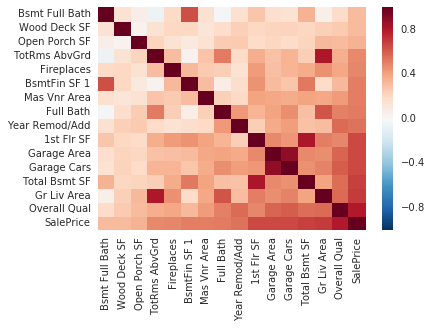

In [6]:
#Generate a correlation heatmap matrix of the numerical features in the training data set
train_subset = new_df[:1460]
correlations = train_subset.corr()
sorted_corrs = correlations['SalePrice'].abs().sort_values(ascending=True)
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat = train_subset[strong_corrs.index].corr()
sns.heatmap(corrmat)

Based on the correlation matrix heatmap, we can tell that the following pairs of columns are strongly correlated:
* Gr Liv Area and TotRms AbvGrd
* Garage Area and Garage Cars

If we read the descriptions of these columns from the data documentation, we can tell that each pair of columns reflects very similar information. Because Gr Liv Area and Garage Area are continuous variables that capture more nuance, let's drop the TotRms AbvGrd and Garage Cars.

In [7]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
final_corr_cols

Bsmt Full Bath    0.315024
Wood Deck SF      0.319104
Open Porch SF     0.344383
Fireplaces        0.485683
BsmtFin SF 1      0.513579
Mas Vnr Area      0.513787
Full Bath         0.518194
Year Remod/Add    0.545219
1st Flr SF        0.657119
Garage Area       0.662397
Total Bsmt SF     0.683403
Gr Liv Area       0.698990
Overall Qual      0.804562
SalePrice         1.000000
Name: SalePrice, dtype: float64

In [10]:
#determine which columns in the data frame should be converted from the categorical data type using dummy codes
all_categorical_columns = new_df.select_dtypes(include=['object']).columns #find only categorical columns
for col in all_categorical_columns:
    print(new_df[col].value_counts())

RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: MS Zoning, dtype: int64
Reg    1859
IR1     979
IR2      76
IR3      16
Name: Lot Shape, dtype: int64
Lvl    2633
HLS     120
Bnk     117
Low      60
Name: Land Contour, dtype: int64
AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64
Inside     2140
Corner      511
CulDSac     180
FR2          85
FR3          14
Name: Lot Config, dtype: int64
Gtl    2789
Mod     125
Sev      16
Name: Land Slope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype:

In [11]:
#Based on the above and intuition we should dummy code the following columns:
categorical_columns = ['Neighborhood', 'Bldg Type', 'Exterior 1st', 'Bsmt Exposure', 'Heating QC', 'Garage Finish']    

dummy_cols = pd.DataFrame()
for col in categorical_columns:
    col_dummies = pd.get_dummies(new_df[col])
    new_df = pd.concat([new_df, col_dummies], axis=1)
    del new_df[col]
    
new_df

,MS Zoning,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,House Style,...,Mn,No,Ex,Fa,Gd,Po,TA,Fin,RFn,Unf
0,RL,31770,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Story,...,0,0,0,1,0,0,0,1,0,0
1,RH,11622,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Story,...,0,1,0,0,0,0,1,0,0,1
2,RL,14267,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Story,...,0,1,0,0,0,0,1,0,0,1
3,RL,11160,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Story,...,0,1,1,0,0,0,0,1,0,0
4,RL,13830,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,2Story,...,0,1,0,0,1,0,0,1,0,0
5,RL,9978,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,2Story,...,0,1,1,0,0,0,0,1,0,0
6,RL,4920,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Story,...,1,0,1,0,0,0,0,1,0,0
7,RL,5005,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,1Story,...,0,1,1,0,0,0,0,0,1,0
8,RL,5389,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Story,...,0,1,1,0,0,0,0,0,1,0
9,RL,7500,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,2Story,...,0,1,0,0,1,0,0,1,0,0


Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale


,Lot Area,Overall Qual,Overall Cond,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Mn,No,Ex,Fa,Gd,Po,TA,Fin,RFn,Unf
0,31770,6,5,1960,112.0,639.0,0.0,441.0,1080.0,1656,...,0,0,0,1,0,0,0,1,0,0
1,11622,5,6,1961,0.0,468.0,144.0,270.0,882.0,896,...,0,1,0,0,0,0,1,0,0,1
2,14267,6,6,1958,108.0,923.0,0.0,406.0,1329.0,1329,...,0,1,0,0,0,0,1,0,0,1
3,11160,7,5,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,1,1,0,0,0,0,1,0,0
4,13830,5,5,1998,0.0,791.0,0.0,137.0,928.0,928,...,0,1,0,0,1,0,0,1,0,0
5,9978,6,6,1998,20.0,602.0,0.0,324.0,926.0,926,...,0,1,1,0,0,0,0,1,0,0
6,4920,8,5,2001,0.0,616.0,0.0,722.0,1338.0,1338,...,1,0,1,0,0,0,0,1,0,0
7,5005,8,5,1992,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,1,1,0,0,0,0,0,1,0
8,5389,8,5,1996,0.0,1180.0,0.0,415.0,1595.0,1616,...,0,1,1,0,0,0,0,0,1,0
9,7500,7,5,1999,0.0,0.0,0.0,994.0,994.0,1028,...,0,1,0,0,1,0,0,1,0,0


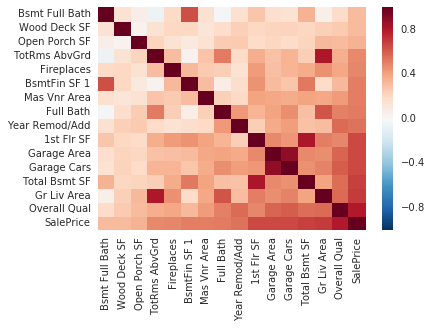

In [12]:
def select_features(df):
    transformed_data = transform_features(data)
    
    #Generate a correlation heatmap matrix of the numerical features in the training data set
    train_subset = transformed_data[:1460]
    correlations = train_subset.corr()
    sorted_corrs = correlations['SalePrice'].abs().sort_values(ascending=True)
    strong_corrs = sorted_corrs[sorted_corrs > 0.3]
    corrmat = train_subset[strong_corrs.index].corr()
    sns.heatmap(corrmat)
    
    final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
    final_corr_cols
    
    #Based on the above and intuition we should dummy code the following columns:
    categorical_columns = ['Neighborhood', 'Bldg Type', 'Exterior 1st', 'Bsmt Exposure', 'Heating QC', 'Garage Finish']    

    dummy_cols = pd.DataFrame()
    for col in categorical_columns:
        col_dummies = pd.get_dummies(transformed_data[col])
        transformed_data = pd.concat([transformed_data, col_dummies], axis=1)
        del transformed_data[col]
    
    #drop unused categorical variables
    categorical_columns_to_drop = ['MS Zoning', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Condition 1', 'Condition 2', 
       'House Style', 'Roof Style', 'Roof Matl', 
       'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Qual', 'Garage Cond',
       'Paved Drive']
    transformed_data = transformed_data.drop(columns=(categorical_columns_to_drop), axis=1)
  
    return transformed_data

select_features(data)

## Train and Test Function

In [89]:
def train_and_test(df, k):
    focused_data = select_features(data)
    #When k equals 0, perform holdout validation
    if k == 0:
        train = focused_data[:1460]
        test = focused_data[1460:]
        #numerical_cols = select_features(train).select_dtypes(include=['number']).columns # all numerical columns
        #numerical_cols_without_SalePrice = numerical_cols.drop(columns=['SalePrice'])

        lr = LinearRegression()
        lr.fit(train.drop(columns=['SalePrice']), train['SalePrice'])

        train_predictions = lr.predict(train.drop(columns=['SalePrice']))
        test_predictions = lr.predict(test.drop(columns=['SalePrice']))

        train_mse = mean_squared_error(train_predictions, train['SalePrice'])
        test_mse = mean_squared_error(test_predictions, test['SalePrice'])

        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)

        return train_rmse, test_rmse
    #When k equals 1, perform simple cross validation
    elif k >= 1:
        if k == 1:
            k=2
        focused_data = select_features(data)
        numerical_cols = select_features(focused_data).select_dtypes(include=['number']).columns # all numerical columns
        df_numerical_cols = focused_data[numerical_cols.values.tolist()]
        #folds = range(1,k)

#         def train_and_validate(df, folds):
#             fold_rmses = []
#             for fold in folds:
#                 kf = KFold(fold, shuffle=True, random_state=1)
#                 model = KNeighborsRegressor()
#                 mses = cross_val_score(model, df.drop(columns=['SalePrice']), df[['SalePrice']], scoring="neg_mean_squared_error", cv=kf)
#                 rmses = np.sqrt(np.absolute(mses))
#                 avg_rmse = np.mean(rmses)
#                 std_rmse = np.std(rmses)
#             return(fold_rmses)
        kf = KFold(k, shuffle=True, random_state=1)
        model = KNeighborsRegressor()
        mses = cross_val_score(model, df_numerical_cols.drop(columns=['SalePrice']), df_numerical_cols[['SalePrice']], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        return(avg_rmse)

        #rmses = train_and_validate(data, k)
        #return np.mean(rmses)
    

Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale


(22288.158810117824, 61930.30674694296)

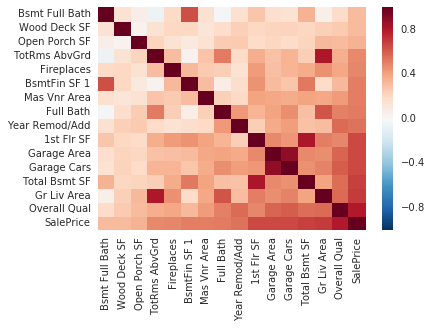

In [21]:
train_and_test(data,0)

Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale
Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale
Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale


44572.3419397737

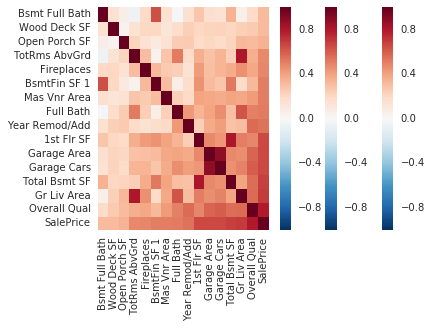

In [90]:
train_and_test(data,1)

Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale
Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale
Drop any column from the data frame with more than 25% missing values
For numerical columns with less than 5% missing values, fill in with the most popular value (mode)
Add column that computes the year until home was remodeled
Drop columns that are not useful or leak data about the final sale


42362.731399456774

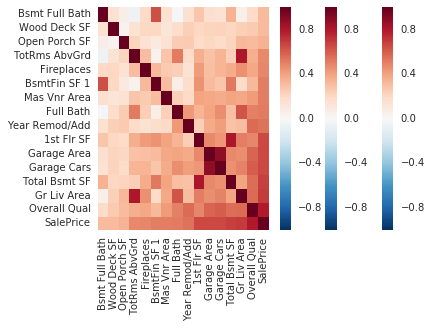

In [91]:
train_and_test(data,4)